<a href="https://colab.research.google.com/github/aletorales/SeminarioCienciaDeDatos/blob/master/WebScrapping_Banxico_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime
import numpy as np

In [0]:
#pip install requests_html
#pip install unidecode

In [0]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

In [0]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

In [8]:
with HTMLSession() as sess:
    r=sess.get(url)
r

<Response [200]>

In [9]:
tbl= r.html.find("table", first=True)
tbl
#table table-striped bmtableview

<Element 'table' class=('table', 'table-striped', 'bmtableview')>

In [10]:
len(tbl.find("tr"))

182

In [0]:
minutas=tbl.find("tr")

In [33]:
#extrae fecha y abstract de cada minuta
qdate="td[class='bmdateview']"
qabst="td[class='bmtextview']"

minutas[0].find(qdate,first=True).text
minutas[0].find(qabst,first=True).text.rstrip(' Texto completo')

'El objetivo para la Tasa de Inter�s Interbancaria a 1 d�a (tasa objetivo) disminuye en 25 puntos base\n'

In [13]:
#extrae la url 
qurl="a[onclick]"
minutas[0].find(qurl,first=True).absolute_links
purl,*_=minutas[0].find(qurl,first=True).absolute_links
purl

'https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/{0DD5A3F4-0B57-8F6A-6F98-1F5048852A35}.pdf'

In [0]:
#Extrayendo todo 
qdate="td[class='bmdateview']"
qabst="td[class='bmtextview']"
qurl="a[onclick]"

data=[]
for minu in minutas:
    date= (minu.find(qdate, first=True)
                .text)
    abst= (minu.find(qabst, first=True)
               .text.rstrip("Texto completo"))
    purl, *_= (minu.find(qurl, first=True)
                 .absolute_links)
    data_fr={
        "date":datetime.strptime(date,"%d/%m/%y"),
        "text": abst,
        "url": purl
    }
    data.append(data_fr)

In [35]:
comunicados=pd.DataFrame(data)
comunicados

,date,text,url
0,2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
1,2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2,2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
3,2019-06-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
4,2019-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
...,...,...,...
177,2000-10-17,"El ""corto"" se aumenta a 310 millones de pesos\n",https://www.banxico.org.mx/publicaciones-y-pre...
178,2000-07-31,"El ""corto"" se aumenta a 280 millones de pesos\n",https://www.banxico.org.mx/publicaciones-y-pre...
179,2000-06-26,"El ""corto"" se aumenta a 230 millones de pesos\n",https://www.banxico.org.mx/publicaciones-y-pre...
180,2000-05-16,"El ""corto"" se aumenta a 200 millones de pesos\n",https://www.banxico.org.mx/publicaciones-y-pre...


In [0]:
###########Prueba
fecha=comunicados["date"][0]
fecha
datetime.strptime(fecha,"%d/%m/%y")
####################

In [0]:
#Filtra después del 15-02-2008 y acomoda de manera ascendente
comunicados_f=(comunicados[comunicados["date"]>=datetime(2008, 2, 15)].set_index("date")
                                                                      .sort_index())

In [39]:
#Convierte archivo a pickle y lo lee
comunicados_f.to_pickle("comunicados-banxico.pkl")
info_df=pd.read_pickle("comunicados-banxico.pkl")
info_df

,text,url
date,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
...,...,...
2019-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2019-06-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...


In [0]:
#Extrae del texto si la tasa de mantiene incrementa o disminuye
extract=pd.Series(info_df["text"])
estado_tasa=extract.str.extract(pat='(mantiene|incrementa|disminuye)',expand=True)
tasa=pd.Series(estado_tasa[0], name="category")  

In [87]:
#full_df=info_df.join(tasa, how="left")
full_df=info_df.assign(category=tasa)
full_df

,text,url,category
date,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa
...,...,...,...
2019-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2019-06-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye


In [47]:
#Cuenta cuántas veces incrementa, disminuye o se mantiene la tasa 
(full_df.groupby("category").count()
                            .drop("url",axis=1))

,text
category,
disminuye,14
incrementa,18
mantiene,72


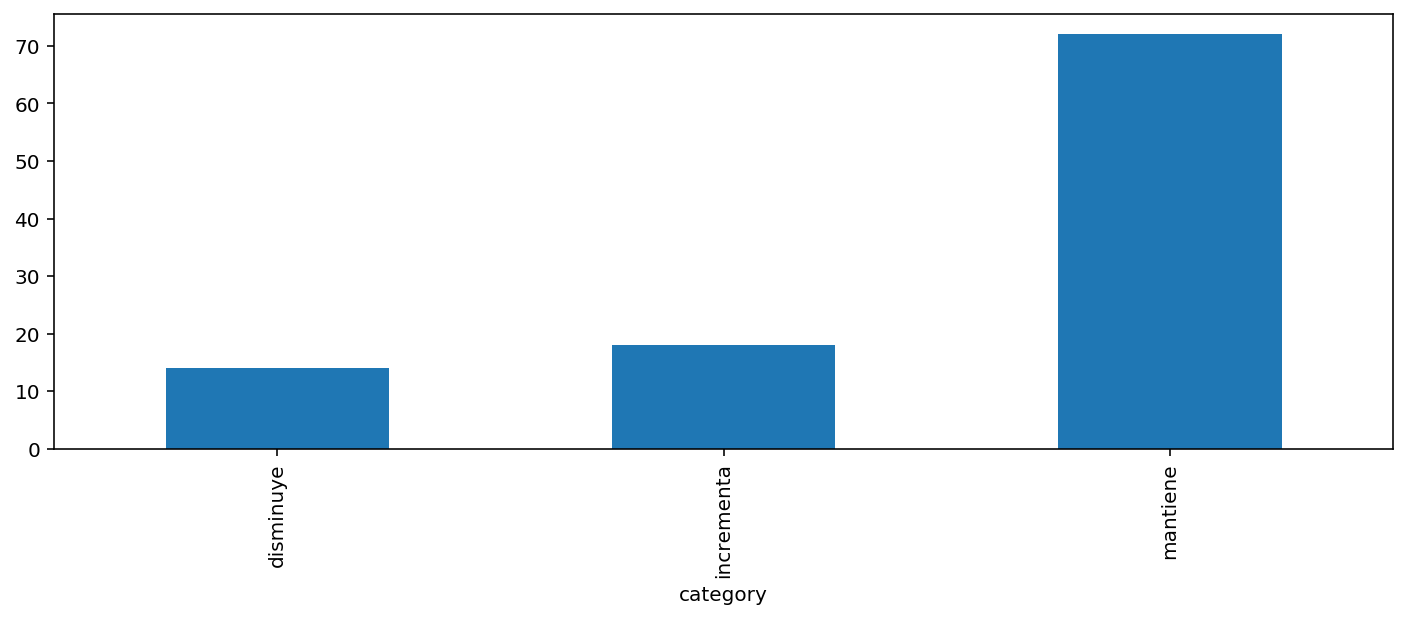

In [86]:
(full_df.groupby("category").count()
                            .drop("url",axis=1)).plot.bar(legend=False,figsize=(12, 4))

In [0]:
##########No funcionó
#def convert(df):
 #   category_aux=df['category']
  #  df.assign(category_aux=category_aux)
   # for i in range(len(df)):
    #    if df['category'][i]=="mantiene":
     #       df['category_aux'][i]==0
      #  elif df['category'][i]=="disminuye":
       #     df['category_aux'][i]==-1
        #else:
         #   df['category_aux'][i]==1
    #return category_aux
    
#full_df.assign(category_aux=convert(full_df))
##########################

In [189]:
#Agrega una columna auxiliar para la gráfica de category
def convert(full_df):
  vector=list(full_df['category'])
  v_aux=[]
  for i in vector:
    if i=="mantiene":
      v_aux.append(0)
    elif i=="disminuye":
      v_aux.append(-1)
    else:
      v_aux.append(1)
  return v_aux

df_aux=full_df.assign(category_aux=convert(full_df))
df_aux

,text,url,category,category_aux
date,,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa,1
...,...,...,...,...
2019-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2019-06-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1


Text(0.5, 0, 'date')

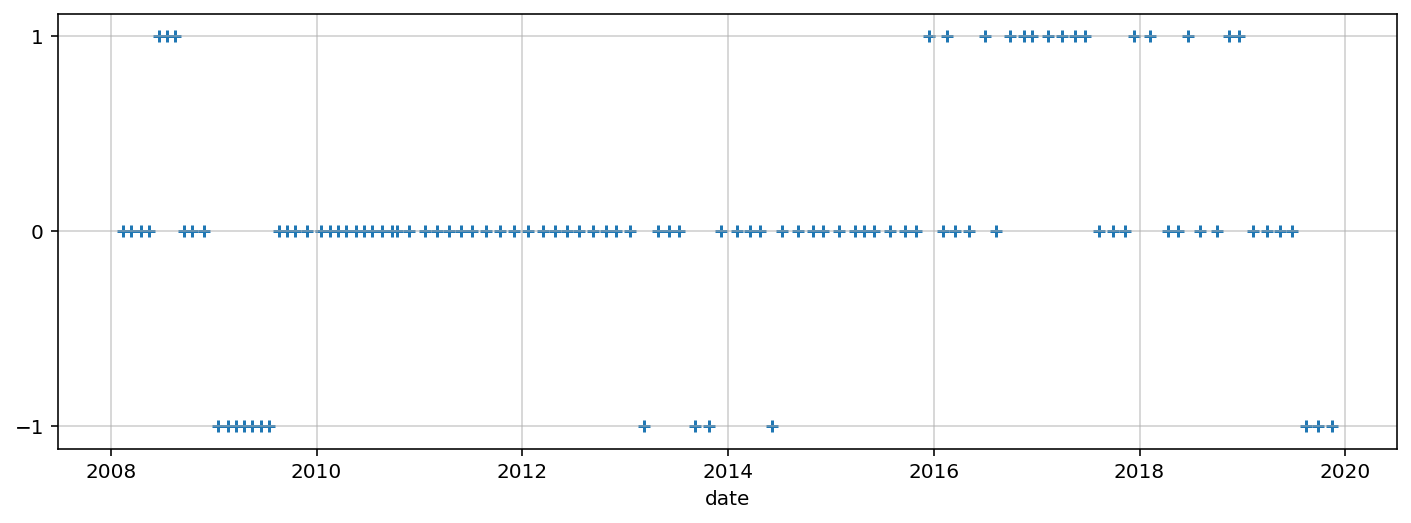

In [199]:
#s=pd.Series(df_aux["category_aux"]
#plt.plot(s.index, s.values)
#df_aux.plot(df_aux.index, 'category_aux',style='o')
#ax = df_aux['category_aux'].plot(style='o')
#df_aux['category_aux'].plot(ax=ax,style='o')
#df_aux[['date','category_aux']].plot('date', figsize=(15,8))
plt.scatter(df_aux.index.tolist(), df_aux['category_aux'],marker="+")  #################################finallyyy
plt.grid(alpha=0.6)
plt.yticks([-1,0,1])
plt.xlabel("date")


In [0]:
########################NO FUNCIONO################################
#pd.Series.plot(df_aux["category_aux"])
#df_aux.index
#def years(dates, fmt="%Y/%m/%d"):
 #   return list(dates.values.astype("datetime64[Y]")

#full_df.groupby("category").agg({full_df.index(): years})
#(full_df.assign(year=lambda v: full_df.index.tolist().astype("datetime64[Y]"))
 #       .pivot_table(index="date", columns="year"))
###################################################################

In [232]:
##Auxiliar para última gráfica
def list_dates(full_df):
  vector=full_df.index.to_list()
  v_aux=[]
  for i in vector:
    v_aux.append(i.year)
  return v_aux

df_aux2=full_df.assign(years=list_dates(full_df))
df_aux2.head()

,text,url,category,years
date,,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,2008
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,2008
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,2008
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,2008
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa,2008


In [257]:
graf_cat=df_aux2.groupby(["years","category"]).count().drop("url",axis=1)
graf_cat

text
years category        
2008  incrementa     3
      mantiene       7
2009  disminuye      7
      mantiene       4
2010  mantiene      11
2011  mantiene       8
2012  mantiene       8
2013  disminuye      3
      mantiene       5
2014  disminuye      1
      mantiene       7
2015  incrementa     1
      mantiene       7
2016  incrementa     5
      mantiene       4
2017  incrementa     5
      mantiene       3
2018  incrementa     4
      mantiene       4
2019  disminuye      3
      mantiene       4

In [271]:
#graf_cat.plot.bar()
#plt.bar(graf_cat, category, width, yerr=menStd)
#plt.bar(graf_cat, womenMeans, width,
             #bottom=menMeans, yerr=womenStd)
             
#Crea tabla dinámica para graficar 
df_pivot = graf_cat.reset_index()
df_pivot = df_pivot.pivot(index='years', columns='category', values='text')
df_pivot.head()

category,disminuye,incrementa,mantiene
years,,,
2008,NaN,3.0,7.0
2009,7.0,NaN,4.0
2010,NaN,NaN,11.0
2011,NaN,NaN,8.0
2012,NaN,NaN,8.0


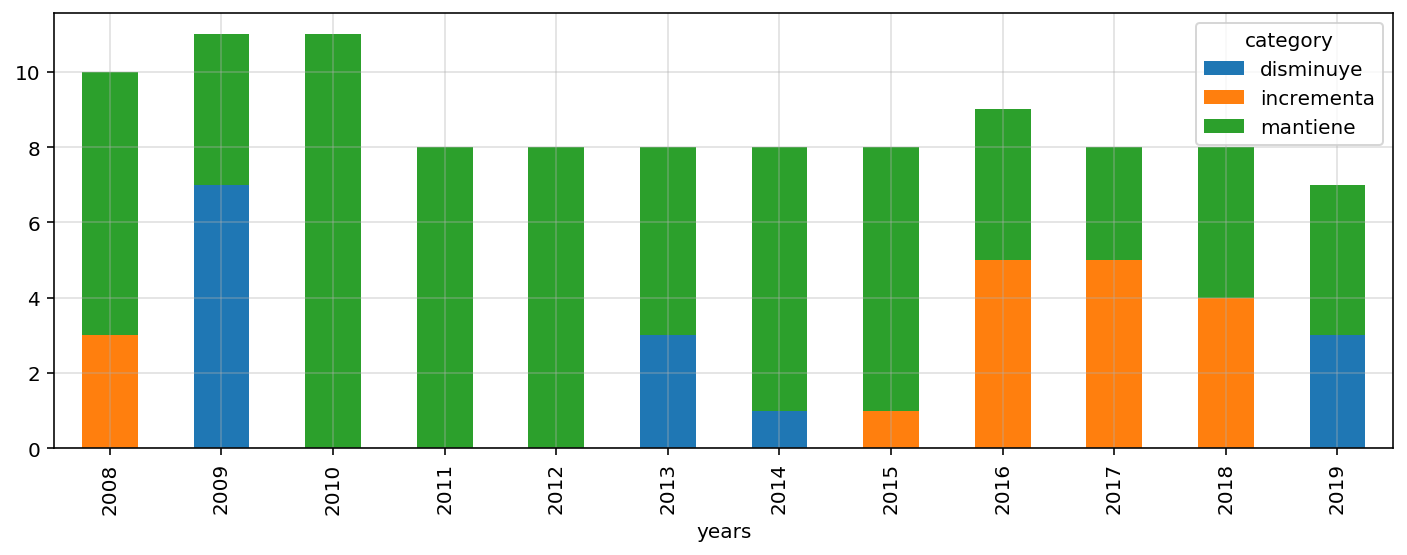

In [281]:
#Grafica
df_pivot.loc[:,['disminuye','incrementa', 'mantiene']].plot.bar(stacked=True, figsize=(12,4))
plt.grid(alpha=0.4)